# Image Classification Network

My goal is to train Convolutional Neural Networks (CNN) to classify CIFAR-10 images. CIFAR-10 is a 10-class image classification dataset with 50,000 training images and 10,000 test images. You can find more info in https://www.cs.toronto.edu/~kriz/cifar.html. You may find more information about PyTorch usage in official documents at https://pytorch.org/tutorials/beginner/basics/intro.html.



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import flatten
import torch.optim as optim
from torch.utils.data import random_split

#### Import and split dataset
Load the CIFAR-10 dataset using `torchvision.datasets.CIFAR10` and use 10% of training images as validation data.

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
training_dataset = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root = "data",
    train = False,
    download = True,
    transform = transform
)
train, val = random_split(training_dataset, [0.9, 0.1])
assert len(train) == 45000
assert len(val) == 5000

100%|██████████| 170498071/170498071 [00:02<00:00, 78065790.95it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#### Build Dataloader
Build PyTorch dataloader based on the dataset and set batchsize to 128. To enhance training robustness, I shuffle the training dataset, promoting diversity in each batch

In [5]:
# Convert datasets to DataLoader

train_loader = DataLoader(train, batch_size = 128, shuffle= True)
val_loader = DataLoader(val, batch_size = 128, shuffle= False)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle= False)

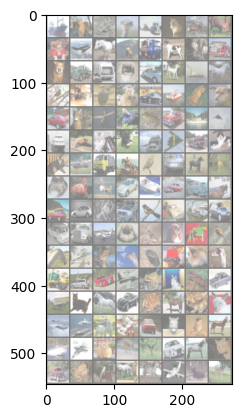

In [6]:
# Visualize one image from CIFAR
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


#### Build a neural network.
I'm constructing convolutional neural networks by gradually adding layers. Initially, I include two convolutional layers, each with a 3x3 kernel size. For the first layer, I opt for 32 filters, while for the second layer, I choose 64 filters. Both layers employ ReLU as the activation function and have a stride set to 2.

Following the convolutional layers, I flatten the input and introduce two additional dense layers. The first dense layer consists of 1024 units, utilizing ReLU activation. Then, I add another dense layer with 10 hidden units and apply softmax activation. This setup fulfills the requirements for my model.

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
    # layer definition
        super(SimpleCNN, self).__init__()
        # creating first cnn layer
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride =2, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride =2, padding = 1)
        # Defining dense layers
        self.dense1 = nn.Linear(64 * 8 * 8, 1024)
        self.dense2 = nn.Linear(1024, 10)

    def forward(self, x):
    # forwarding definition
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        # Flatten:
        x = x.view(-1, 64*8*8)
        x = self.dense1(x)
        x = nn.functional.relu(x)
        x = self.dense2(x)
        return x
model = SimpleCNN()



#### Define loss and optimizer.
 I'm defining the loss function and optimizer for my model. I choose the cross-entropy loss, which is well-suited for classification tasks. For optimization, I employ stochastic gradient descent (SGD) with a learning rate (lr) of 0.01 and momentum set to 0.9.

In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (dense1): Linear(in_features=4096, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=10, bias=True)
)

#### Training and testing loop.
I'm executing the training and testing loop for my model over 20 epochs. This process involves iteratively training the model on the training dataset and evaluating its performance on the testing dataset. If you're running this on a system without powerful GPUs, each epoch might take around 5-10 minutes to complete. If the wait times become excessive, consider using smaller networks or reducing the number of epochs for debugging purposes. However, remember to revert the network definition code and the number of epochs back to their original values once debugging is complete.

In [9]:
# Training loop
def train_loop(model, train_loader, val_loader, criterion, optimizer):
    n_epochs = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels in train_loader:
            # do forward-backward propogation, and update the model
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # compute the validation loss and accuracy
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            

        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}')

In [10]:
# Evaluation
def test_loop(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cpu"), labels.to("cpu")
            outputs = model(inputs)
            # compute the validation loss and accuracy
            # should be the same as the code for validation set
            test_loss += criterion(outputs, labels).item()
            predicted = torch.argmax(outputs.data, dim=1)
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {correct/total:.4f}')


In [11]:
#train_loop(model, train_loader, val_loader, criterion, optimizer)
test_loop(model, test_loader, criterion)
# the right implementation should reach an accuracy over 60%, on both val and test set

Test Loss: 2.3041, Test Accuracy: 0.0858


#### Regularization
Implementing regularization by adding a dropout layer with a dropout rate of 0.5 between the two dense layers. This dropout layer will help prevent overfitting by randomly dropping 50% of the units' outputs from the previous layer during training. All other hyperparameters remain unchanged

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
    # layer definition
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.dense1 = nn.Linear(64 * 8 * 8, 1024)
        self.dropout = nn.Dropout(p=0.5)
        self.dense2 = nn.Linear(1024, 10)

    def forward(self, x):
    # forwarding definition
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

model = SimpleCNN()

In [13]:

# do not forget to redefine the loss and optimizer!
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [ ]:
train_loop(model, train_loader, val_loader, criterion, optimizer)
test_loop(model, test_loader, criterion)
# the right implementation should lead to an accuracy boost of at least 1.5%, on both val and test set

Epoch 1/20, Loss: 1.7205, Accuracy: 0.3868
